In [1]:
from queue import Queue
from threading import Thread
import redis
import json
boxv=[]
detectworking=True

def worker(input_q, output_q):
        global detectworking
        print("worker")
        while True:
            if input_q.full():
                print("full break1")
#                break
            frame = input_q.get()
            if detectworking==False:
                print('detectworking')
                continue;
            start1 = time.time()
            box,newframe=detect_objectsbyframe(frame)
            end1= time.time()
            print("detect_objectsbyframe",(end1-start1))
            if box is not None:
                x,y=box
                boxv.append(box)
                print("box1=",x)
                if  x>70.0:
                    if detectworking:
                        print("capture photo")
                        capturephoto(frame,9999)
#                        capturephoto(newframe,10000)
                    print("send to redis")
                    r.rpush("apriltag", json.dumps({"x":x,"y":y}))
                    
                detectworking=False
#            if bFind:
#                capturephoto(frame,1000)
            output_q.put("hello")
            print('shape =',frame.shape)
            
        print("worker exit")
input_q = Queue(2)  # fps is better if queue is higher but then more lags
output_q = Queue()
for i in range(1):
        t = Thread(target=worker, args=(input_q, output_q))
        t.daemon = True
        t.start()
print("test")
#input_q.put('hello')

workertest



In [2]:
import subprocess
import redis
positionv=[]
r = redis.Redis(host='localhost', port=6379, db=0)
def addposition(x,y):
        positionv.append((x,y))
    
def isDetect(line):
    return line.startswith("detection=")
def toPosition(line):
      plotline=line[10:]
      plotv=plotline.split(",")
      return plotv
def apriltag(imagename):
#    imagename='/Users/aadebuger/GEXT/cloud2019/machinevision/data/tz_belt_output20190417_5/40.jpg'
    
#    lines=subprocess.getoutput('/Users/aadebuger/GEXT/github2019/apriltags/xcodebuild/Debug/apriltag_demo {0}'.format(imagename))
    lines=subprocess.getoutput('/home/aadebugergf/Ai/cloud2019/apriltags/build/apriltag_demo {0}'.format(imagename))
    linev=lines.split("\n")
    detectionv=filter(lambda item:isDetect(item),linev)
    positionv=map(lambda item:toPosition(item),detectionv)
    return list(positionv)
import numpy as np 
def getBox(plotv):
            arr2=np.asarray(plotv[1:],float)
            rect=(arr2[6],arr2[7],arr2[4]-arr2[0],arr2[1]-arr2[5])
            return (rect[0]+rect[2]/2,rect[1]+rect[3]/2)

def computeposition(x,y):
    yuandian=(853.5124299065,706.912679109)
    kx = -0.8937383178 
    ky = -0.8729680915
    scarax = yuandian[0] + kx*x 
    scaray = yuandian[1] + ky*y
    return (scarax,scaray)
r = redis.Redis(host='localhost', port=6379, db=0)
import base64
#import cStringIO
import sys
import tempfile
import time
MODEL_BASE = '/Users/aadebuger/GEXT/github2019/models/research'
MODEL_BASE = '/home/aadebugergf/Ai/github2019/models/research'


sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')


import numpy as np
from PIL import Image
from PIL import ImageDraw
import tensorflow as tf
from utils import label_map_util




PATH_TO_CKPT = '/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

content_types = {'jpg': 'image/jpeg',
                 'jpeg': 'image/jpeg',
                 'png': 'image/png'}
extensions = sorted(content_types.keys())


def is_image():
  def _is_image(form, field):
    if not field.data:
      raise ValidationError()
    elif field.data.filename.split('.')[-1].lower() not in extensions:
      raise ValidationError()

  return _is_image





class ObjectDetector(object):

  def __init__(self):
    self.detection_graph = self._build_graph()
    self.sess = tf.Session(graph=self.detection_graph)

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)

  def _build_graph(self):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    return detection_graph

  def _load_image_into_numpy_array(self, image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

  def detect(self, image):
    image_np = self._load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = self.detection_graph
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    boxes = graph.get_tensor_by_name('detection_boxes:0')
    scores = graph.get_tensor_by_name('detection_scores:0')
    classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')

    (boxes, scores, classes, num_detections) = self.sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    boxes, scores, classes, num_detections = map(
        np.squeeze, [boxes, scores, classes, num_detections])

    return boxes, scores, classes.astype(int), num_detections
 

def draw_bounding_box_on_image(image, box, color='red', thickness=4):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  if (right-left)<100:
        print("too lower")
        return None
  print("rect,width="+str(right-left)+"height="+str(bottom-top))
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  print('(left, right, top, bottom)',(left, right, top, bottom))
  centerx=left+(right-left)/2
  centery=top+ (bottom-top)/2
  print("center=",centerx,"y=",centery)
  scaraxy=(centerx*4/3,centery*4/3)
  print("scara xy",scaraxy)
  return scaraxy
    
from io import BytesIO
def encode_image(image):
  image_buffer = BytesIO()
  image.save(image_buffer, format='PNG')
  imagevalue = image_buffer.getvalue()
  base64str=base64.b64encode(imagevalue).decode()

  imgstr = 'data:image/png;base64,{:s}'.format(
     base64str )
  return imgstr


def detect_objects(image_path):
  start = time.time()
  
  image = Image.open(image_path).convert('RGB')
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
  print(num_detections)
  new_images = {}
  for i in range(int(num_detections)):
    
    if scores[i] < 0.8: continue
    print("scres[i",scores[i])
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)

  result = {}
#  result['original'] = encode_image(image.copy())
#  print(new_images)
  count = 0 
  for cls, new_image in new_images.items():
    category = client.category_index[cls]['name']
    print(category)
    result[category] = encode_image(new_image)
    new_image.save("{0}.jpg".format(count))
    count=count+1
  end = time.time()
  print("execute2 time",(end-start)) 
  return result

def detect_objectsbyframe(frame):
  start = time.time()
  
#  image = Image.open(image_path).convert('RGB')
  height, width, channels = frame.shape
  print("height",height)
  image= Image.frombytes("RGB", (width,height), frame.tostring())
  boxes, scores, classes, num_detections = client.detect(image)
  end = time.time()
#  print("execute1 time",(end-start)) 
    
  image.thumbnail((480, 480), Image.ANTIALIAS)
#  print(num_detections)
  new_images = {}
  print("test1")
  for i in range(int(num_detections)):

    if scores[i] < 0.8: continue
    print("scres[i",scores[i])
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    box=draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)
    if box is not None:
        print("scarxbox",box)
        return (box,new_images[cls])
    return (None,None)
#  result['original'] = encode_image(image.copy())
#  print(new_images)
  return (None,None)


PATH_TO_CKPT='/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'
PATH_TO_CKPT='/home/aadebugergf/Ai/models/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'


PATH_TO_CKPT='/home/aadebugergf/Ai/models/fastrcnnstbmodelrtx2/frozen_inference_graph.pb'
client = ObjectDetector()

In [3]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
#cap = cv2.VideoCapture(1)
#/home/aadebugergf/aixgf/tzimagedata/beltvideo/belt_output2019062101.mp4
videoname='/home/aadebugergf/aixgf/tzimagedata/beltvideo/'+'belt_output2019062101.mp4'
cap = cv2.VideoCapture(videoname)

ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
detectworking=True
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)
boxv=[]
input_q.queue.clear()
def videooutput():
    global ivalue
    global detectworking
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            print("put")
            start10=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end10=time.time()
                print("detect time",(end10-start10))
                bFirst=False
        if detectworking!=False:
            img_str = cv2.imencode('.jpg', frame)[1].tostring()

            image1.value=img_str
        else:
                file = open("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(10000), "rb")
                fileimage1 = file.read()
                file.close()
                image1.value=fileimage1
        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Button(description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

put
height 480
frame none
capture end
test1
detect_objectsbyframe 4.54189133644104
shape = (480, 640, 3)


In [13]:
cap.release()

In [14]:
import pandas as pd
boxf = pd.DataFrame(boxv)
boxf.describe()

,0,1
count,1.000000,1.000000
mean,127.047141,396.177464
std,NaN,NaN
min,127.047141,396.177464
25%,127.047141,396.177464
50%,127.047141,396.177464
75%,127.047141,396.177464
max,127.047141,396.177464


In [ ]:
bFirst=False

In [7]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
#cap = cv2.VideoCapture(1)
cap = cv2.VideoCapture('/home/aadebugergf/aixgf/tzimagedata/beltvideo/belt_output2019062101.mp4')

ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)
boxv=[]
input_q.queue.clear()
def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            print("put")
            start1=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end1=time.time()
                print("detect time",(end1-start1))
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")
import pandas as pd
boxf = pd.DataFrame(boxv)
boxf.describe()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

Button(description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

put
detect time 1.621246337890625e-05
height 480
put
detect time 2.8133392333984375e-05
put
detect time 1.5020370483398438e-05
put
test1
shape = (480, 640, 3)
full break
height 480
detect time 0.08664584159851074
put
test1
shape = (480, 640, 3)
full break
height 480detect time
 0.0874946117401123
put
test1
shape = (480, 640, 3)
full break
height 480
detect time 0.08146953582763672
put
test1
shape = (480, 640, 3)
full break
height 480
detect time 0.08019685745239258
put
test1
shape = (480, 640, 3)
full break
height 480
detect time 0.08622241020202637
put
test1
shape = (480, 640, 3)
full break
height 480
detect time 0.08185720443725586
put
test1
shape = (480, 640, 3)
full break
height 480
detect time 0.08576512336730957
put
test1
shape = (480, 640, 3)
full break
height 480
detect time 0.09224367141723633
put
test1
shape = (480, 640, 3)
full break
height 480detect time
 0.08366203308105469
put
test1
scres[i 0.993393
boxes [0.6862545  0.00584898 0.9499919  0.15356202]
too lower
shape = (48

put
test1
scres[i 0.97636
boxes [0.6905987  0.01281378 0.9679142  0.22823323]
rect,width=103.40133860707283height=99.83357906341553
(left, right, top, bottom) (6.1506132781505585, 109.55195188522339, 248.61554145812988, 348.4491205215454)
center= 57.851282581686974 y= 298.53233098983765
scara xy (77.1350434422493, 398.0431079864502)
scarxbox (77.1350434422493, 398.0431079864502)
box (77.1350434422493, 398.0431079864502)
box= (77.1350434422493, 398.0431079864502)
shape = (480, 640, 3)
full break
height 480
detect time 0.2702653408050537
put
test1
scres[i 0.955501
boxes [0.6775459  0.02078579 0.9556398  0.23687343]
rect,width=103.7220686674118height=100.11379480361938
(left, right, top, bottom) (9.977179169654846, 113.69924783706665, 243.91652584075928, 344.03032064437866)
center= 61.83821350336075 y= 293.97342324256897
scara xy (82.45095133781433, 391.9645643234253)
scarxbox (82.45095133781433, 391.9645643234253)
box (82.45095133781433, 391.9645643234253)
box= (82.45095133781433, 391.96

put
test1
scres[i 0.9964988
boxes [0.6799354  0.04650671 0.9628336  0.28252178]
rect,width=113.28723549842834height=101.84334754943848
(left, right, top, bottom) (22.32322096824646, 135.6104564666748, 244.7767424583435, 346.620090007782)
center= 78.96683871746063 y= 295.69841623306274
scara xy (105.28911828994751, 394.264554977417)
scarxbox (105.28911828994751, 394.264554977417)
box (105.28911828994751, 394.264554977417)
box= (105.28911828994751, 394.264554977417)
shape = (480, 640, 3)
full break
height 480
detect time 0.09033727645874023
put
test1
scres[i 0.99255544
boxes [0.69110477 0.05752186 0.9819446  0.27936748]
rect,width=106.48589372634888height=104.70234632492065
(left, right, top, bottom) (27.61049509048462, 134.0963888168335, 248.7977170944214, 353.50006341934204)
center= 80.85344195365906 y= 301.1488902568817
scara xy (107.80458927154541, 401.5318536758423)
scarxbox (107.80458927154541, 401.5318536758423)
box (107.80458927154541, 401.5318536758423)
box= (107.80458927154541,

detect time 0.08397459983825684
put
test1
scres[i 0.9728986
boxes [0.685389   0.09029065 0.97516906 0.31360835]
rect,width=107.19249486923218height=104.32082891464233
(left, right, top, bottom) (43.33951234817505, 150.53200721740723, 246.7400336265564, 351.06086254119873)
center= 96.93575978279114 y= 298.90044808387756
scara xy (129.24767971038818, 398.5339307785034)
scarxbox (129.24767971038818, 398.5339307785034)
box (129.24767971038818, 398.5339307785034)
box= (129.24767971038818, 398.5339307785034)
shape = (480, 640, 3)
full break
height 480
detect time 0.08518838882446289
put
test1
scres[i 0.97147524
boxes [0.68962884 0.10065901 0.98526764 0.321183  ]
rect,width=105.85151553153992height=106.42996788024902
(left, right, top, bottom) (48.316322565078735, 154.16783809661865, 248.26638221740723, 354.69635009765625)
center= 101.2420803308487 y= 301.48136615753174
scara xy (134.9894404411316, 401.975154876709)
scarxbox (134.9894404411316, 401.975154876709)
box (134.9894404411316, 401.97

put
test1
scres[i 0.97758377
boxes [0.6873196  0.13723369 0.96897054 0.3616035 ]
rect,width=107.69750833511353height=101.39434576034546
(left, right, top, bottom) (65.87217092514038, 173.5696792602539, 247.43504762649536, 348.8293933868408)
center= 119.72092509269714 y= 298.1322205066681
scara xy (159.6279001235962, 397.5096273422241)
scarxbox (159.6279001235962, 397.5096273422241)
box (159.6279001235962, 397.5096273422241)
box= (159.6279001235962, 397.5096273422241)
shape = (480, 640, 3)
full break
height detect time480
 0.08550000190734863
put
test1
scres[i 0.9884133
boxes [0.6810378  0.13177033 0.96157485 0.37400326]
rect,width=116.27180814743042height=100.99334478378296
(left, right, top, bottom) (63.249757289886475, 179.5215654373169, 245.173602104187, 346.16694688796997)
center= 121.38566136360168 y= 295.6702744960785
scara xy (161.84754848480225, 394.227032661438)
scarxbox (161.84754848480225, 394.227032661438)
box (161.84754848480225, 394.227032661438)
box= (161.84754848480225,

put
test1
scres[i 0.98449254
boxes [0.67762554 0.1777232  0.9807936  0.40467384]
rect,width=108.93630981445312height=109.14050102233887
(left, right, top, bottom) (85.30713558197021, 194.24344539642334, 243.94519329071045, 353.0856943130493)
center= 139.77529048919678 y= 298.5154438018799
scara xy (186.3670539855957, 398.02059173583984)
scarxbox (186.3670539855957, 398.02059173583984)
box (186.3670539855957, 398.02059173583984)
box= (186.3670539855957, 398.02059173583984)
shape = (480, 640, 3)
full break
height 480
detect time 0.0900115966796875
put
test1
scres[i 0.9872851
boxes [0.6704678  0.17466807 0.95633453 0.40920877]
rect,width=112.57953643798828height=102.91202545166016
(left, right, top, bottom) (83.8406753540039, 196.4202117919922, 241.3684058189392, 344.28043127059937)
center= 140.13044357299805 y= 292.8244185447693
scara xy (186.84059143066406, 390.4325580596924)
scarxbox (186.84059143066406, 390.4325580596924)
box (186.84059143066406, 390.4325580596924)
box= (186.840591430

put
test1
scres[i 0.96929663
boxes [0.67830926 0.22300246 0.98828554 0.4498143 ]
rect,width=108.86967658996582height=111.59146070480347
(left, right, top, bottom) (107.04118251800537, 215.9108591079712, 244.1913342475891, 355.7827949523926)
center= 161.47602081298828 y= 299.98706459999084
scara xy (215.30136108398438, 399.9827527999878)
scarxbox (215.30136108398438, 399.9827527999878)
box (215.30136108398438, 399.9827527999878)
box= (215.30136108398438, 399.9827527999878)
shape = (480, 640, 3)
full break
height 480
detect time 0.09322667121887207
put
test1
scres[i 0.9910732
boxes [0.6830143  0.22207843 0.96957153 0.4596132 ]
rect,width=114.01669263839722height=103.1606125831604
(left, right, top, bottom) (106.59764528274536, 220.61433792114258, 245.88513851165771, 349.0457510948181)
center= 163.60599160194397 y= 297.4654448032379
scara xy (218.1413221359253, 396.6205930709839)
scarxbox (218.1413221359253, 396.6205930709839)
box (218.1413221359253, 396.6205930709839)
box= (218.141322135

detect time 0.0850687026977539
put
test1
scres[i 0.99281454
boxes [0.6819877  0.26537472 0.9675396  0.50024486]
rect,width=112.7376651763916height=102.79868602752686
(left, right, top, bottom) (127.3798656463623, 240.1175308227539, 245.51557302474976, 348.3142590522766)
center= 183.7486982345581 y= 296.9149160385132
scara xy (244.99826431274414, 395.8865547180176)
scarxbox (244.99826431274414, 395.8865547180176)
box (244.99826431274414, 395.8865547180176)
box= (244.99826431274414, 395.8865547180176)
shape = (480, 640, 3)
full break
height 480
detect time 0.09816145896911621
put
test1
scres[i 0.88232684
boxes [0.67978543 0.27383792 0.9819488  0.49153414]
rect,width=104.49418544769287height=108.77881050109863
(left, right, top, bottom) (131.44220352172852, 235.9363889694214, 244.72275495529175, 353.5015654563904)
center= 183.68929624557495 y= 299.11216020584106
scara xy (244.9190616607666, 398.8162136077881)
scarxbox (244.9190616607666, 398.8162136077881)
box (244.9190616607666, 398.8162

detect time 0.08275556564331055
put
test1
scres[i 0.95099664
boxes [0.67843753 0.3052539  0.9622504  0.5372287 ]
rect,width=111.34790897369385height=102.17263698577881
(left, right, top, bottom) (146.5218687057495, 257.86977767944336, 244.2375111579895, 346.4101481437683)
center= 202.19582319259644 y= 295.3238296508789
scara xy (269.5944309234619, 393.7651062011719)
scarxbox (269.5944309234619, 393.7651062011719)
box (269.5944309234619, 393.7651062011719)
box= (269.5944309234619, 393.7651062011719)
shape = (480, 640, 3)
full break
height 480
detect time 0.09106326103210449
put
test1
scres[i 0.9454536
boxes [0.6771077  0.30517974 0.9613352  0.53759843]
rect,width=111.56096935272217height=102.32189655303955
(left, right, top, bottom) (146.48627758026123, 258.0472469329834, 243.75876903533936, 346.0806655883789)
center= 202.26676225662231 y= 294.91971731185913
scara xy (269.6890163421631, 393.2262897491455)
scarxbox (269.6890163421631, 393.2262897491455)
box (269.6890163421631, 393.226289

put
test1
scres[i 0.9627871
boxes [0.6829074  0.34962574 0.968807   0.5781803 ]
rect,width=109.70619678497314height=102.9238486289978
(left, right, top, bottom) (167.8203535079956, 277.52655029296875, 245.8466649055481, 348.7705135345459)
center= 222.67345190048218 y= 297.308589220047
scara xy (296.89793586730957, 396.411452293396)
scarxbox (296.89793586730957, 396.411452293396)
box (296.89793586730957, 396.411452293396)
box= (296.89793586730957, 396.411452293396)
shape = (480, 640, 3)
full break
height 480
detect time 0.08801651000976562
put
test1
scres[i 0.946741
boxes [0.6812193  0.34733984 0.974317   0.58365875]
rect,width=113.43307971954346height=105.51518440246582
(left, right, top, bottom) (166.72312259674072, 280.1562023162842, 245.2389407157898, 350.7541251182556)
center= 223.43966245651245 y= 297.9965329170227
scara xy (297.9195499420166, 397.3287105560303)
scarxbox (297.9195499420166, 397.3287105560303)
box (297.9195499420166, 397.3287105560303)
box= (297.9195499420166, 397.

detect time 0.2703428268432617
put
test1
scres[i 0.9608838
boxes [0.6818401  0.39348358 0.97082865 0.62191063]
rect,width=109.64498519897461height=104.03587102890015
(left, right, top, bottom) (188.87211799621582, 298.51710319519043, 245.46244382858276, 349.4983148574829)
center= 243.69461059570312 y= 297.48037934303284
scara xy (324.9261474609375, 396.64050579071045)
scarxbox (324.9261474609375, 396.64050579071045)
box (324.9261474609375, 396.64050579071045)
box= (324.9261474609375, 396.64050579071045)
shape = (480, 640, 3)
full break
height 480
detect time 0.0831458568572998
put
test1
scres[i 0.970874
boxes [0.6713031  0.3944139  0.95336765 0.6286774 ]
rect,width=112.44649887084961height=101.54324054718018
(left, right, top, bottom) (189.31866645812988, 301.7651653289795, 241.66911363601685, 343.212354183197)
center= 245.5419158935547 y= 292.44073390960693
scara xy (327.38922119140625, 389.9209785461426)
scarxbox (327.38922119140625, 389.9209785461426)
box (327.38922119140625, 389.92

put
test1
scres[i 0.99022794
boxes [0.67208683 0.43336174 0.9548754  0.6655949 ]
rect,width=111.47190570831299height=101.80388689041138
(left, right, top, bottom) (208.01363468170166, 319.48554039001465, 241.95126056671143, 343.7551474571228)
center= 263.74958753585815 y= 292.8532040119171
scara xy (351.66611671447754, 390.47093868255615)
scarxbox (351.66611671447754, 390.47093868255615)
box (351.66611671447754, 390.47093868255615)
box= (351.66611671447754, 390.47093868255615)
shape = (480, 640, 3)
full break
height 480
detect time 0.08476901054382324
put
test1
scres[i 0.95156807
boxes [0.68208915 0.44548452 0.9773573  0.66476876]
rect,width=105.25643348693848height=106.2965440750122
(left, right, top, bottom) (213.83256912231445, 319.08900260925293, 245.55209398269653, 351.84863805770874)
center= 266.4607858657837 y= 298.70036602020264
scara xy (355.2810478210449, 398.2671546936035)
scarxbox (355.2810478210449, 398.2671546936035)
box (355.2810478210449, 398.2671546936035)
box= (355.28

put
test1
scres[i 0.966472
boxes [0.6676045  0.47653776 0.9449971  0.7079571 ]
rect,width=111.0812759399414height=99.86132383346558
(left, right, top, bottom) (228.73812675476074, 339.81940269470215, 240.33762216567993, 340.1989459991455)
center= 284.27876472473145 y= 290.2682840824127
scara xy (379.0383529663086, 387.0243787765503)
scarxbox (379.0383529663086, 387.0243787765503)
box (379.0383529663086, 387.0243787765503)
box= (379.0383529663086, 387.0243787765503)
shape = (480, 640, 3)
full break
height 480
detect time 0.09514045715332031
put
test1
scres[i 0.9704414
boxes [0.67730445 0.4825042  0.95028037 0.7170135 ]
rect,width=112.5644588470459height=98.27133178710938
(left, right, top, bottom) (231.6020107269287, 344.1664695739746, 243.82960081100464, 342.100932598114)
center= 287.88424015045166 y= 292.9652667045593
scara xy (383.84565353393555, 390.6203556060791)
scarxbox (383.84565353393555, 390.6203556060791)
box (383.84565353393555, 390.6203556060791)
box= (383.84565353393555, 3

detect time 0.08693480491638184
time ok
capture end


,0,1
count,186.000000,186.000000
mean,235.932787,395.653987
std,98.818201,3.434889
min,69.206101,386.839485
25%,148.212234,393.232495
50%,235.167394,395.877120
75%,321.870651,397.944911
max,403.129692,404.204164


test1
scres[i 0.9804899
boxes [0.6673369 0.5169217 0.9505646 0.7510541]
rect,width=112.3835563659668height=101.9619870185852
(left, right, top, bottom) (248.12241554260254, 360.50597190856934, 240.241277217865, 342.2032642364502)
center= 304.31419372558594 y= 291.2222707271576
scara xy (405.75225830078125, 388.29636096954346)
scarxbox (405.75225830078125, 388.29636096954346)
box (405.75225830078125, 388.29636096954346)
box= (405.75225830078125, 388.29636096954346)
shape = (480, 640, 3)
full break
height 480
test1
scres[i 0.9770159
boxes [0.6756491 0.5228024 0.9559491 0.7539926]
rect,width=110.97129821777344height=100.90800762176514
(left, right, top, bottom) (250.94515800476074, 361.9164562225342, 243.23367834091187, 344.141685962677)
center= 306.43080711364746 y= 293.68768215179443
scara xy (408.5744094848633, 391.5835762023926)
scarxbox (408.5744094848633, 391.5835762023926)
box (408.5744094848633, 391.5835762023926)
box= (408.5744094848633, 391.5835762023926)
shape = (480, 640, 3)
h

In [ ]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
#cap = cv2.VideoCapture(1)
cap = cv2.VideoCapture(1)

ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)
boxv=[]
input_q.queue.clear()
def videooutput():
    global ivalue
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            print("put")
            start10=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end10=time.time()
                print("detect time",(end10-start10))
                bFirst=False
        img_str = cv2.imencode('.jpg', frame)[1].tostring()

        image1.value=img_str
        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")

In [8]:
import pandas as pd
boxf = pd.DataFrame(boxv)
boxf.describe()

,0,1
count,9.000000,9.000000
mean,311.604589,393.553457
std,148.346995,2.708138
min,90.509725,389.822688
25%,205.084615,391.408954
50%,314.068947,393.815246
75%,424.725609,395.339656
max,520.074692,396.943974


In [121]:
from PIL import Image
import matplotlib.pyplot as plt

In [129]:
img = Image.open('/home/aadebugergf/aixgf/tzimagedata/beltvision/object9999.jpg')

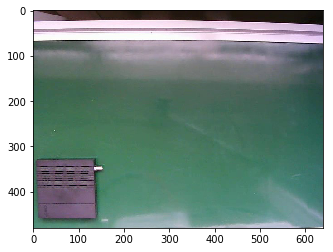

In [130]:
plt.imshow(img)

execute1 time 0.26873779296875
200.0
scres[i 0.99996555
boxes [0.3183863  0.54709953 0.6176843  0.79498184]
rect,width=118.98350715637207height=107.74728655815125
(left, right, top, bottom) (262.60777473449707, 381.59128189086914, 114.61906313896179, 222.36634969711304)
center= 322.0995283126831 y= 168.49270641803741
scara xy (429.46603775024414, 224.65694189071655)
bicycle
execute2 time 0.34221720695495605
1



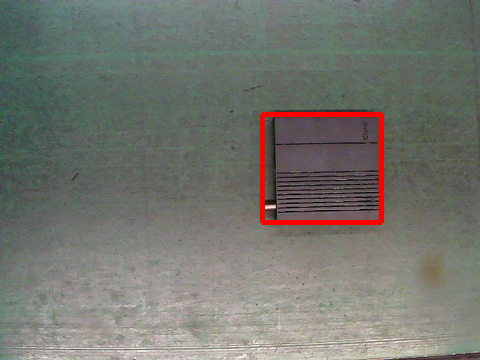

In [134]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122538.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 1.226158618927002
200.0
scres[i 0.99996555
boxes [0.3183863  0.54709953 0.6176843  0.79498184]
rect,width=118.98350715637207height=107.74728655815125
(left, right, top, bottom) (262.60777473449707, 381.59128189086914, 114.61906313896179, 222.36634969711304)
center= 322.0995283126831 y= 168.49270641803741
scara xy (429.46603775024414, 224.65694189071655)
bicycle
execute2 time 1.3292698860168457
1



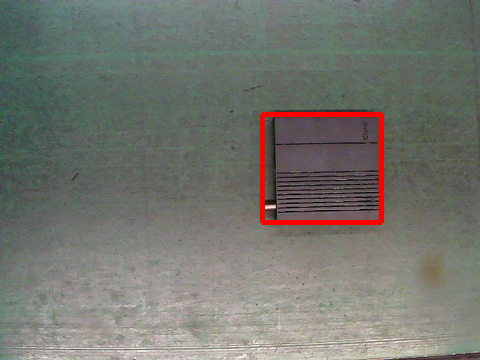

In [6]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122538.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

execute1 time 0.2782449722290039
200.0
scres[i 0.99996555
boxes [0.3183863  0.54709953 0.6176843  0.79498184]
rect,width=118.98350715637207height=107.74728655815125
(left, right, top, bottom) (262.60777473449707, 381.59128189086914, 114.61906313896179, 222.36634969711304)
center= 322.0995283126831 y= 168.49270641803741
scara xy (429.46603775024414, 224.65694189071655)
bicycle
execute2 time 0.3506453037261963
1



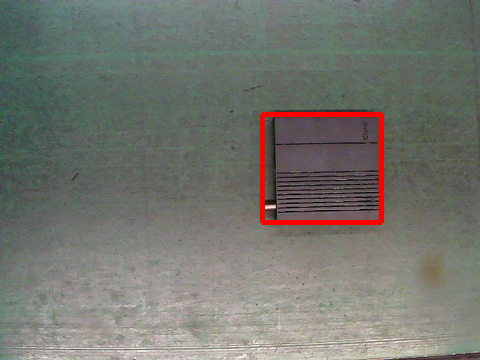

In [22]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122538.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))

In [ ]:
import ipywidgets as widgets
belttestposition=(520.0,364.36,-90,-90,'皮带视频测试点')
belttestendposition=(235.00,364.36,-90,-90,'皮带测试结束点')
import cv2
#cap = cv2.VideoCapture(1)
#/home/aadebugergf/aixgf/tzimagedata/beltvideo/belt_output2019062101.mp4
videoname='/home/aadebugergf/aixgf/tzimagedata/beltvideo/'+'belt_output2019062101.mp4'
cap = cv2.VideoCapture(2)

ret, frame = cap.read()
img_str = cv2.imencode('.jpg', frame)[1].tostring()
import time
image1=widgets.Image(
    value=img_str,
    format='jpg',
    width=300,
    height=400,
)
display(image1)

button1=widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)
bExit=False
ivalue=0
detectworking=True
def capturephoto(frame,count):
    
    cv2.imwrite("/home/aadebugergf/aixgf/tzimagedata/beltvision/object{0}.jpg".format(count),frame)

def on_button_clicked(b):
    global bExit
    global ivalue
    print("Button clicked.",bExit)
    bExit=True
    ivalue=10
    print(time.time())
def isExit1():
    global bExit
    return bExit
button1.on_click(on_button_clicked)
display(button1)
boxv=[]
input_q.queue.clear()
def videooutput():
    global ivalue
    global detectworking
    bFirst=False
    count = 0 
    start = time.time()
    while(True):
        ret, frame = cap.read()
        if frame is None:
            print("frame none")
            break
        if bFirst is False:
            print("put")
            start10=time.time()
            input_q.put(frame)
            bFirst = True
        if output_q.empty():
                pass
        else:
                data=output_q.get()
                end10=time.time()
                print("detect time",(end10-start10))
                bFirst=False
        if detectworking!=False:
            img_str = cv2.imencode('.jpg', frame)[1].tostring()

            image1.value=img_str

        end = time.time()
        if ( (end-start)>60):
            print("time ok")
            break
videooutput()
cap.release()
print("capture end")

In [6]:
cap.release()

In [ ]:
result=detect_objects('/home/aadebugergf/aixgf/tzimagedata/dqn/object20190426122538.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['bicycle']))